<a href="https://colab.research.google.com/github/qraxiss/learning-data-science/blob/main/machine-learning/classification/lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data & Libs

In [65]:
# Libs
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier 
from google.colab import drive
from warnings import filterwarnings
filterwarnings('ignore')

# Data
drive.mount('/content/gdrive')
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/learning-data-science-main/machine-learning/datas/diabetes.csv")
df = df.dropna()
df.index = np.arange(df.shape[0])

# X&y
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

# Test Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=31)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Model

In [66]:
lgbm_model = LGBMClassifier().fit(X_train, y_train)

# Predict

In [67]:
print("Basic Accuracy Score",accuracy_score(y_test, lgbm_model.predict(X_test)))
print("CV Accuracy Score",cross_val_score(lgbm_model,
                                          X_test, 
                                          y_test, 
                                          cv=10).mean())

Basic Accuracy Score 0.7532467532467533
CV Accuracy Score 0.7309782608695652


# Model Tuning

In [69]:
lgbm_params = {
        'n_estimators': [100, 500],
        'subsample': [0.6, 0.8],
        'max_depth': [3, 4],
        'learning_rate': [0.1,0.01],
        "min_child_samples": [5,10]}

lgbm = LGBMClassifier()
lgbm_cv = GridSearchCV(lgbm, lgbm_params, cv = 3, n_jobs = -1, verbose = 2)
lgbm_cv_model = lgbm_cv.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [70]:
print("En iyi skor:" + str(lgbm_cv_model.best_score_))
print("En iyi parametreler: " + str(lgbm_cv_model.best_params_))
params = pd.Series(lgbm_cv_model.best_params_)
params

En iyi skor:0.7653631284916201
En iyi parametreler: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 5, 'n_estimators': 100, 'subsample': 0.6}


learning_rate          0.01
max_depth              3.00
min_child_samples      5.00
n_estimators         100.00
subsample              0.60
dtype: float64

## Tuned Model

In [71]:
lgbm = LGBMClassifier(learning_rate = float(params[0]), max_depth=int(params[1]), min_samples_split = int(params[2]), n_estimators=int(params[3]), subsample=float(params[4]))
lgbm_tuned = lgbm.fit(X_train, y_train) 

In [73]:
print("Basic Accuracy Score",accuracy_score(y_test, lgbm_tuned.predict(X_test)))
print("CV Accuracy Score",cross_val_score(lgbm_tuned,
                                          X_test, 
                                          y_test, 
                                          cv=10).mean())

Basic Accuracy Score 0.7445887445887446
CV Accuracy Score 0.7485507246376811


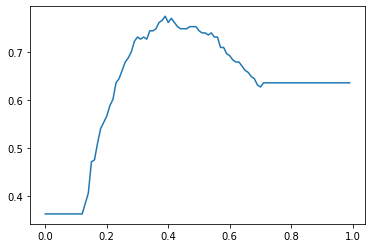

In [74]:
# Yüzdesel Oranlar
y_probs = pd.DataFrame(lgbm_tuned.predict_proba(X_test))
max = []
for j in np.arange(0,1,0.01):
  y_pred = np.array([1 if i > j else 0 for i in list(y_probs[1])])
  max.append([j ,accuracy_score(y_test, y_pred)])

max = np.array(max)

# Plot
import seaborn as sns
sns.lineplot(y=max[:,1], x=max[:,0])

# Plot

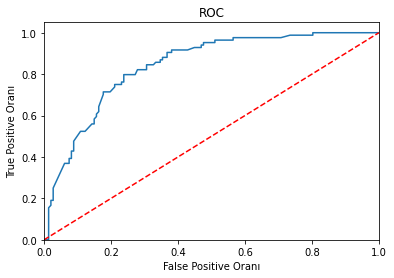

In [75]:
logit_roc_auc = roc_auc_score(y_test, lgbm_tuned.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test, lgbm_tuned.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()